    problem                               search  expansions  tests  \
0         1                 breadth_first_search          43     56   
1         1            breadth_first_tree_search        1458   1459   
2         1             depth_first_graph_search          12     13   
3         1                 depth_limited_search         101    271   
4         1                  uniform_cost_search          55     57   
5         1      recursive_best_first_search h_1        4229   4230   
6         1   greedy_best_first_graph_search h_1           7      9   
7         1                     astar_search h_1          55     57   
8         1  astar_search h_ignore_preconditions          41     43   
9         2                 breadth_first_search        3343   4609   
10        2            breadth_first_tree_search           0      0   
11        2             depth_first_graph_search        1669   1670   
12        2                 depth_limited_search           0      0   
13    

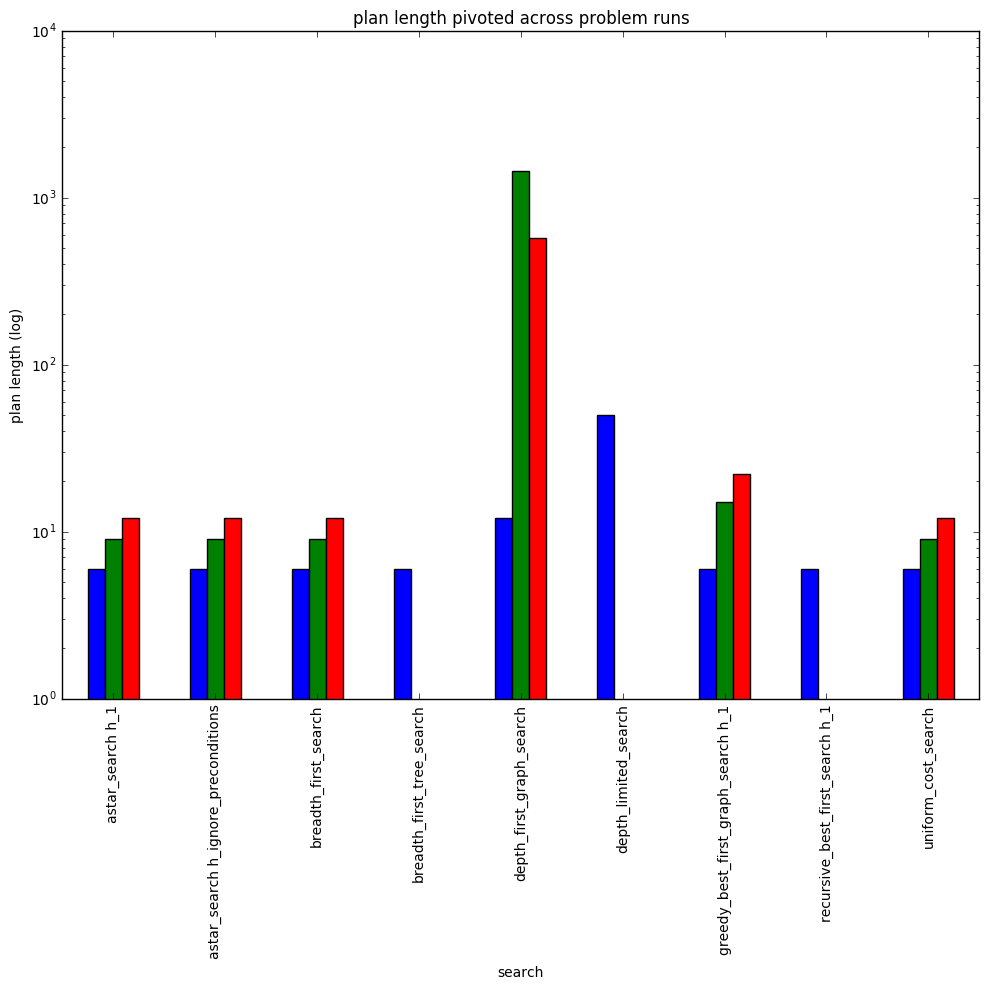

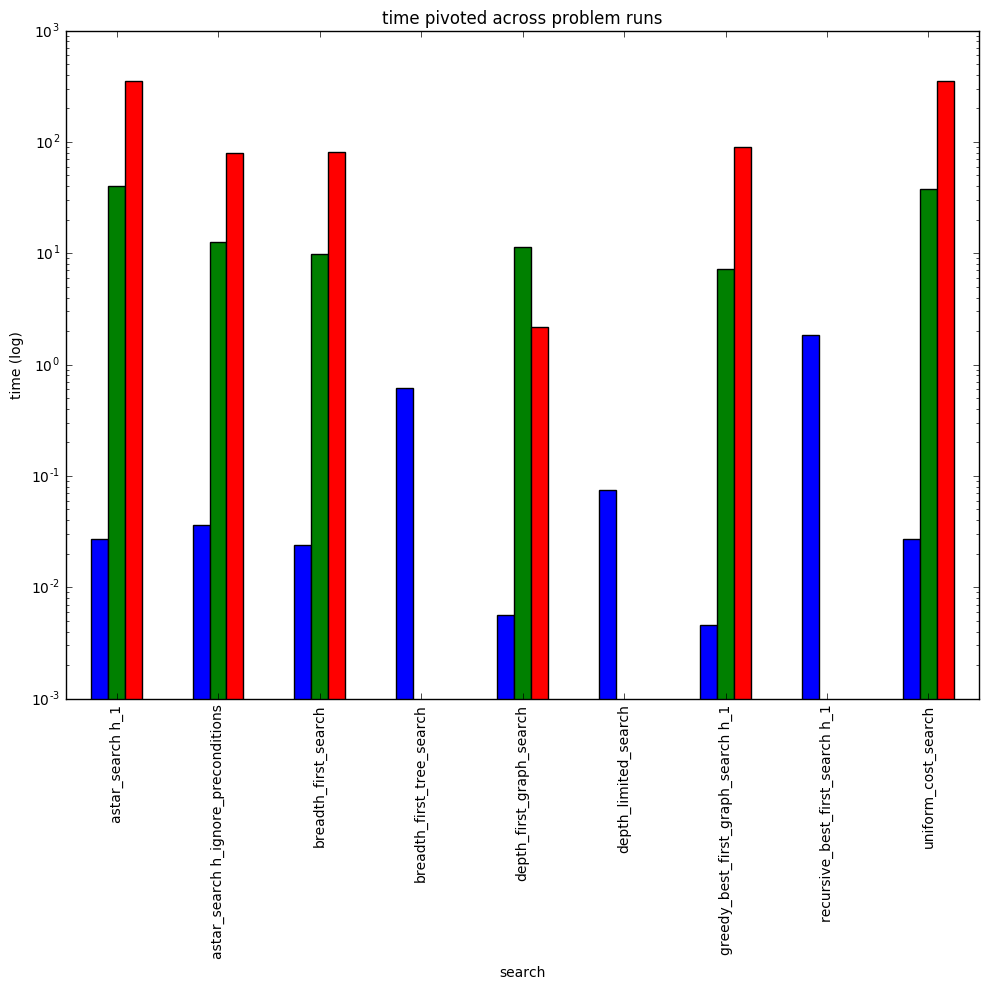

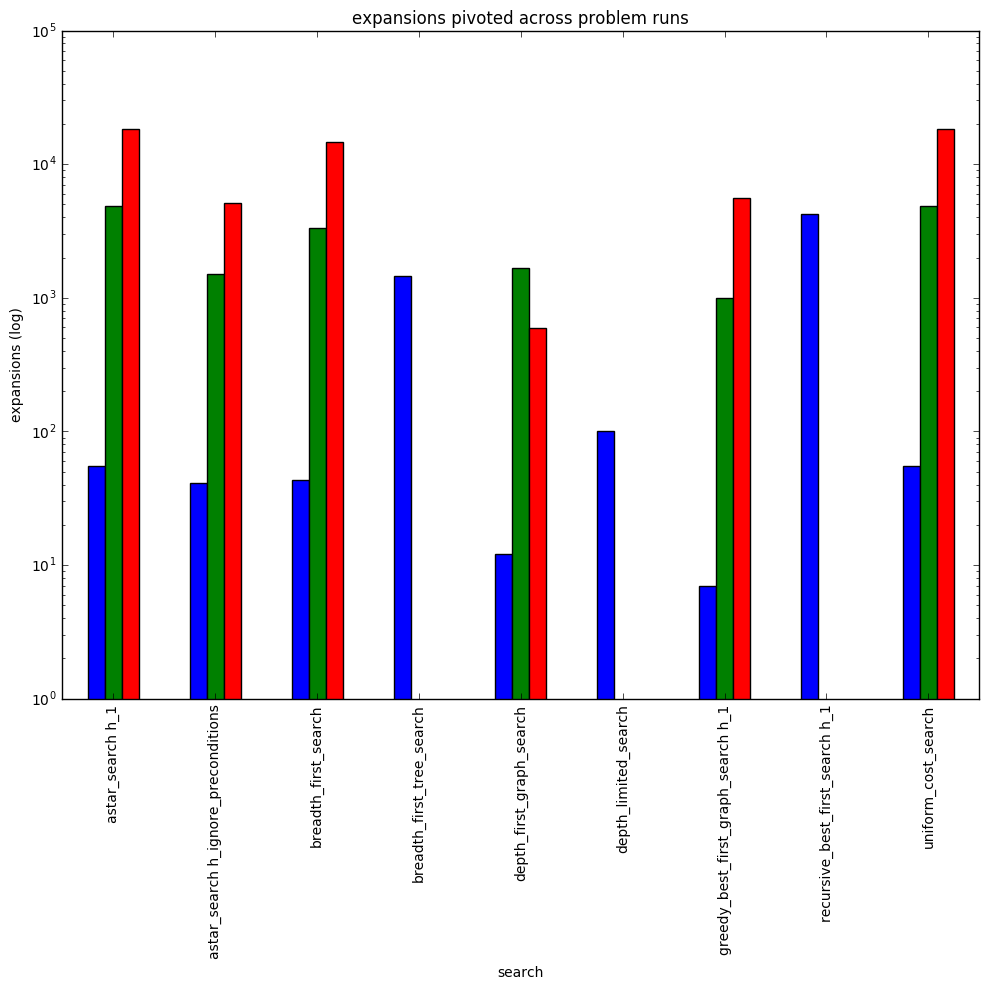

In [6]:
import matplotlib.pyplot as plt
import pandas as pd


search_map = {
    1: 'breadth_first_search',
    2: 'breadth_first_tree_search',
    3: 'depth_first_graph_search',
    4: 'depth_limited_search',
    5: 'uniform_cost_search',
    6: 'recursive_best_first_search h_1',
    7: 'greedy_best_first_graph_search h_1',
    8: 'astar_search h_1',
    9: 'astar_search h_ignore_preconditions',
    10: 'astar_search h_pg_levelsum'
}



df=pd.read_csv('uninformed.csv')
df['search'] = df['search'].map(search_map)
print(df)

labels = []
idx=1

for y in ['plan length', 'time', 'expansions']:
    a = df.pivot(index='search', columns='problem', values=y).plot(kind='bar', logy=True, legend=False, figsize=(10,10))
    a.set_ylabel(y+" (log)")
    a.set_title(y+" pivoted across problem runs")
    fig = a.get_figure()
    plt.tight_layout()
    fig.savefig("img_{}.png".format(y.replace(' ','_')))
plt.show()